# **ACTIVIDAD 2: REDES NEURONALES CONVOLUCIONALES**

Nombre de los participantes de la actividad:

- Juliana Amézquita 
- Andrés Serna
- Carlos Chávez
- Evelyn Quishpe

---

En esta actividad, vamos a trabajar con Convolutional Neural Networks para resolver un problema de clasificación de imágenes. En particular, vamos a clasificar imágenes de personajes de la conocida serie de los Simpsons.

Como las CNN profundas son un tipo de modelo bastante avanzado y computacionalmente costoso, se recomienda hacer la práctica en Google Colaboratory con soporte para GPUs. En [este enlace](https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d) se explica cómo activar un entorno con GPUs. *Nota: para leer las imágenes y estandarizarlas al mismo tamaño se usa la librería opencv. Esta ĺibrería está ya instalada en el entorno de Colab, pero si trabajáis de manera local tendréis que instalarla.*

<center><img src="https://i.imgur.com/i8zIGqX.jpg" style="text-align: center" height="300px"></center>

El dataset a utilizar consiste en imágenes de personajes de los Simpsons extraídas directamente de capítulos de la serie. Este dataset ha sido recopilado por [Alexandre Attia](http://www.alexattia.fr/) y es más complejo que el dataset de Fashion MNIST que hemos utilizado hasta ahora. Aparte de tener más clases (vamos a utilizar los 18 personajes con más imágenes), los personajes pueden aparecer en distintas poses, en distintas posiciones de la imagen o con otros personajes en pantalla (si bien el personaje a clasificar siempre aparece en la posición predominante).

El dataset de training puede ser descargado desde aquí:

[Training data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60) (~500MB)

Por otro lado, el dataset de test puede ser descargado de aquí:

[Test data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8) (~10MB)

Antes de empezar la práctica, se recomienda descargar las imágenes y echarlas un vistazo.


# **Carga de los datos**

In [1]:
import cv2
import os
import numpy as np 
import keras
from tensorflow import keras
import matplotlib.pyplot as plt
import glob
import tensorflow as tf

In [2]:
# DATOS DE ENTRENAMIENTO

keras.utils.get_file(fname="simpsons_train.tar.gz", 
                     origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60")

# Se descomprime el archivo

!tar -xzf /root/.keras/datasets/simpsons_train.tar.gz -C /root/.keras/datasets


# DATOS DE PRUEBA

keras.utils.get_file(fname="simpsons_test.tar.gz", 
                     origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8")

# Se descomprime el archivo

!tar -xzf /root/.keras/datasets/simpsons_test.tar.gz -C /root/.keras/datasets

10674176/10658925 [==============================] - 3s 0us/step


In [3]:
# VISUALIZACIÓN DEL ARCHIVO

# Se descomprime el archivo en tmp para visualizar

# !tar -xzf /root/.keras/datasets/simpsons_train.tar.gz -C /tmp/simpsons

In [4]:
# Esta variable contiene un mapeo de número de clase a personaje.
# Utilizamos sólo los 18 personajes del dataset que tienen más imágenes.
MAP_CHARACTERS = {
    0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson',
    3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel', 
    7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lisa_simpson', 
    11: 'marge_simpson', 12: 'milhouse_van_houten', 13: 'moe_szyslak', 
    14: 'ned_flanders', 15: 'nelson_muntz', 16: 'principal_skinner', 17: 'sideshow_bob'
}

# Vamos a standarizar todas las imágenes a tamaño 64x64
IMG_SIZE = 60

In [5]:
def load_train_set(dirname, map_characters, verbose=True):
    """Esta función carga los datos de training en imágenes.
    
    Como las imágenes tienen tamaños distintas, utilizamos la librería opencv
    para hacer un resize y adaptarlas todas a tamaño IMG_SIZE x IMG_SIZE.
    
    Args:
        dirname: directorio completo del que leer los datos
        map_characters: variable de mapeo entre labels y personajes
        verbose: si es True, muestra información de las imágenes cargadas
     
    Returns:
        X, y: X es un array con todas las imágenes cargadas con tamaño
                IMG_SIZE x IMG_SIZE
              y es un array con las labels de correspondientes a cada imagen
    """
    X_train = []
    y_train = []
    for label, character in map_characters.items():        
        files = os.listdir(os.path.join(dirname, character))
        images = [file for file in files if file.endswith("jpg")]
        if verbose:
          print("Leyendo {} imágenes encontradas de {}".format(len(images), character))
        for image_name in images:
            image = cv2.imread(os.path.join(dirname, character, image_name))
            X_train.append(cv2.resize(image,(IMG_SIZE, IMG_SIZE)))
            y_train.append(label)
    return np.array(X_train), np.array(y_train)

In [6]:
def load_test_set(dirname, map_characters, verbose=True):
    """Esta función funciona de manera equivalente a la función load_train_set
    pero cargando los datos de test."""
    X_test = []
    y_test = []
    reverse_dict = {v: k for k, v in map_characters.items()}
    for filename in glob.glob(dirname + '/*.*'):
        char_name = "_".join(filename.split('/')[-1].split('_')[:-1])
        if char_name in reverse_dict:
            image = cv2.imread(filename)
            image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
            X_test.append(image)
            y_test.append(reverse_dict[char_name])
    if verbose:
        print("Leídas {} imágenes de test".format(len(X_test)))
    return np.array(X_test), np.array(y_test)


In [7]:
# Cargamos los datos. Si no estás trabajando en colab, cambia los paths por
# los de los ficheros donde hayas descargado los datos.

DATASET_TRAIN_PATH_COLAB = "/root/.keras/datasets/simpsons"
DATASET_TEST_PATH_COLAB = "/root/.keras/datasets/simpsons_testset"

X, y = load_train_set(DATASET_TRAIN_PATH_COLAB, MAP_CHARACTERS)
X_t, y_t = load_test_set(DATASET_TEST_PATH_COLAB, MAP_CHARACTERS)

Leyendo 913 imágenes encontradas de abraham_grampa_simpson
Leyendo 623 imágenes encontradas de apu_nahasapeemapetilon
Leyendo 1342 imágenes encontradas de bart_simpson
Leyendo 1193 imágenes encontradas de charles_montgomery_burns
Leyendo 986 imágenes encontradas de chief_wiggum
Leyendo 469 imágenes encontradas de comic_book_guy
Leyendo 457 imágenes encontradas de edna_krabappel
Leyendo 2246 imágenes encontradas de homer_simpson
Leyendo 498 imágenes encontradas de kent_brockman
Leyendo 1206 imágenes encontradas de krusty_the_clown
Leyendo 1354 imágenes encontradas de lisa_simpson
Leyendo 1291 imágenes encontradas de marge_simpson
Leyendo 1079 imágenes encontradas de milhouse_van_houten
Leyendo 1452 imágenes encontradas de moe_szyslak
Leyendo 1454 imágenes encontradas de ned_flanders
Leyendo 358 imágenes encontradas de nelson_muntz
Leyendo 1194 imágenes encontradas de principal_skinner
Leyendo 877 imágenes encontradas de sideshow_bob
Leídas 890 imágenes de test


In [8]:
# Vamos a barajar aleatoriamente los datos. Esto es importante ya que si no
# lo hacemos y, por ejemplo, cogemos el 20% de los datos finales como validation
# set, estaremos utilizando solo un pequeño número de personajes, ya que
# las imágenes se leen secuencialmente personaje a personaje.

perm = np.random.permutation(len(X))
X, y = X[perm], y[perm]

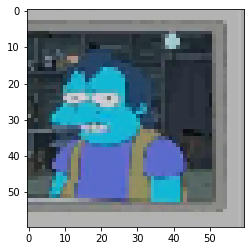

In [9]:
# VISUALIZACIÓN DE IMÁGENES

# Siempre es preferible trabajar en blanco y negro
plt.imshow(X_t[8]) 

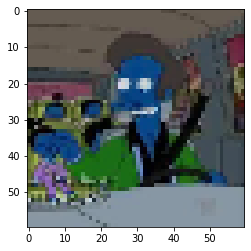

In [10]:
plt.imshow(X_t[800]) 

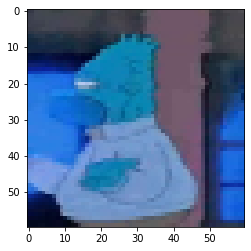

In [11]:
plt.imshow(X_t[6]) 

## Ejercicio propuesto

Utilizando Convolutional Neural Networks con Keras, entrenar un clasificador que sea capaz de reconocer personajes en imágenes de los Simpsons con una accuracy en el dataset de test de, al menos, **85%**. Redactar un informe analizando varias de las alternativas probadas y los resultados obtenidos.

A continuación se detallan una serie de aspectos orientativos que podrían ser analizados en vuestro informe (no es necesario tratar todos ellos ni mucho menos, esto son ideas orientativas de aspectos que podéis explorar):

*   Análisis de los datos a utilizar.
*   Análisis de resultados, obtención de métricas de *precision* y *recall* por clase y análisis de qué clases obtienen mejores o peores resultados.
*   Análisis visual de los errores de la red. ¿Qué tipo de imágenes o qué personajes dan más problemas a nuestro modelo?
*   Comparación de modelos CNNs con un modelo de Fully Connected para este problema.
*   Utilización de distintas arquitecturas CNNs, comentando aspectos como su profundidad, hiperparámetros utilizados, optimizador, uso de técnicas de regularización, *batch normalization*, etc.
*   [ *algo más difícil* ] Utilización de *data augmentation*. Esto puede conseguirse con la clase [ImageDataGenerator](https://keras.io/preprocessing/image/#imagedatagenerator-class) de Keras.

Notas: 
* Recuerda partir los datos en training/validation para tener una buena estimación de los valores que nuestro modelo tendrá en los datos de test, así como comprobar que no estamos cayendo en overfitting. Una posible partición puede ser 80 / 20.
* No es necesario mostrar en el notebook las trazas de entrenamiento de todos los modelos entrenados, si bien una buena idea seria guardar gráficas de esos entrenamientos para el análisis. Sin embargo, **se debe mostrar el entrenamiento completo del mejor modelo obtenido y la evaluación de los datos de test con este modelo**.
* Las imágenes **no están normalizadas**. Hay que normalizarlas como hemos hecho en trabajos anteriores.
* El test set del problema tiene imágenes un poco más "fáciles", por lo que es posible encontrarse con métricas en el test set bastante mejores que en el training set.

## **DESARROLLO DE LA ACTIVIDAD**

In [12]:
# EXPLORACIÓN DE LAS IMÁGENES

# a) Se explora las imágenes tanto en tamaño como en forma

print(X_t[6].shape)
print(X_t.max())

(60, 60, 3)
255


El tamaño de cada imagen es de 60 x 60 pixeles.Contienen 3-bits que
equivale a 8 colores

16
[[[167 177 147]
  [169 180 148]
  [174 185 152]
  ...
  [103  93  59]
  [191 195 183]
  [180 192 196]]

 [[172 184 151]
  [174 184 152]
  [175 184 152]
  ...
  [122 110  75]
  [154 154 140]
  [182 194 193]]

 [[178 183 155]
  [181 182 156]
  [180 182 153]
  ...
  [136 114  65]
  [127 112  70]
  [127 116  78]]

 ...

 [[102  86  19]
  [102  87  18]
  [102  87  18]
  ...
  [ 71  33  47]
  [ 68  30  43]
  [ 70  33  43]]

 [[103  87  18]
  [103  87  18]
  [103  87  18]
  ...
  [ 52  39   5]
  [ 52  39   6]
  [ 51  38   5]]

 [[103  88  16]
  [103  87  18]
  [103  87  18]
  ...
  [ 49  40   3]
  [ 49  40   3]
  [ 49  40   3]]]


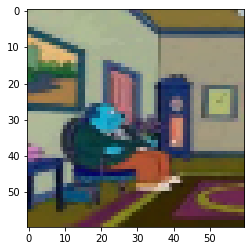

In [13]:
# b) Se verifica las matrices de las imágenes 
import numpy as np
np.set_printoptions(linewidth=200)
import matplotlib.pyplot as plt
plt.imshow(X_t[0], cmap="gray") # recordad que siempre es preferible trabajar en blanco y negro
#
print(y[0])
print(X_t[0])

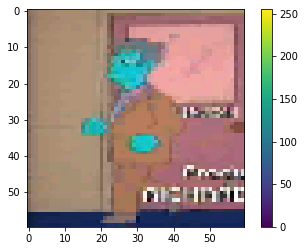

In [14]:
plt.figure()
plt.imshow(X[6])
plt.colorbar()
plt.grid(False)
plt.show()

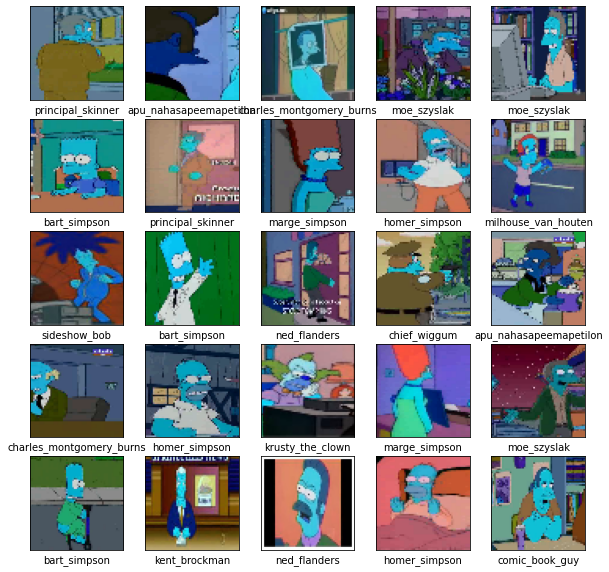

In [15]:
# c) VERIFICACIÓN DE IMÁGENES

# Desplegamos las primeras 25 imagenes de los datos de entrenamiento y desplegamos el nombre de cada clase debajo de cada imagen.

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X[i], cmap=plt.cm.binary)
    plt.xlabel(MAP_CHARACTERS[y[i]])
plt.show()

# **CONSTRUCCIÓN DEL MODELO**

In [16]:


# CARGA DE LIBRERÍAS

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras
import tensorflow.keras

# Librerías para el modelamiento de las redes convulcionales 

# Librería Sequential para trabajar en capas sobre la red neuronal
from keras.models import Sequential 

# Max Pooling2D para reducción de dimensiones (alto y ancho)
from keras.layers import MaxPooling2D
# Como el input es una matriz, necesitamos pasarlo a un vector para que pueda ser procesado por la entrada de la red 
# utilizando Flatten
from keras.layers import Flatten

# Librerías para la construcción de la red neuronal convulcional
from keras.layers import Dense, Dropout, Conv2D, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint

from pathlib import Path
import os

# Librería para el manejo de imágenes: visión artificial
import cv2

# Librerías para la evaluación del modelo de la red nueronal 
# Métricas de evaluación

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from keras.optimizer_v2.adam import Adam



In [17]:
# CONVERTIR LAS IMÁGENES EN VECTOR 

# Número de categorías a clasificar (18 imágenes definidas)
num_classes = 18

# Se convierte el vector de etiquetas en valores numéricos
label_encoder = LabelEncoder()

# Se codifican los datos de las etiquetas para los datos del entrenamiento (Train) como los de validación (Test)
y_train = label_encoder.fit_transform(y)
y_test = label_encoder.fit_transform(y_t)

# Se conviente los vectores creados en una matriz (class matrix) para su procesamiento
y_train_tf = tensorflow.keras.utils.to_categorical(y_train, num_classes)
y_test_tf = tensorflow.keras.utils.to_categorical(y_test, num_classes)

In [18]:
# CONSTRUCCIÓN DEL MODELO CON REDES NEURONALES CONVULCIONALES

model = tf.keras.models.Sequential([
    # La entrada de la imagen es de 60 x 60 con color de 3 bytes (8 colores)
    # Primera convolución
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(60, 60, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    # Segunda convolución
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Tercera convolución
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Cuarta convolución
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Capa para unidimensionalizar la entrada multidimensional
    # Transición de la capa convolucional a la capa oculta
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # Capa oculta de 512 neuronas
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(18, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 58, 58, 64)        1792      
                                                                 
 batch_normalization (BatchN  (None, 58, 58, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 29, 29, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 64)       0         
 2D)                                                             
                                                        

In [19]:
 # COMPILACIÓN DEL MODELO 

 # Para la compilación del modelo, se emplean las métricas: pérdida (loss) y precisión (accuracy)

 model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [20]:
# ENTRENAMIENTO DE MODELO

# Para el entrenamiento del modelo se usó 40 épocas con las  que se alcanzó una precisión mayor al 80%

history = model.fit(X,y_train_tf, validation_steps=3, verbose=1,epochs=40, batch_size=1000,validation_split=0.2)   

Epoch 1/40
16/16 [==============================] - 17s 240ms/step - loss: 2.8630 - accuracy: 0.1303 - val_loss: 3.3693 - val_accuracy: 0.1107
Epoch 2/40
16/16 [==============================] - 3s 175ms/step - loss: 2.4031 - accuracy: 0.2549 - val_loss: 2.5829 - val_accuracy: 0.2270
Epoch 3/40
16/16 [==============================] - 3s 176ms/step - loss: 2.0869 - accuracy: 0.3560 - val_loss: 2.2933 - val_accuracy: 0.2793
Epoch 4/40
16/16 [==============================] - 3s 175ms/step - loss: 1.8551 - accuracy: 0.4314 - val_loss: 2.3113 - val_accuracy: 0.3210
Epoch 5/40
16/16 [==============================] - 3s 176ms/step - loss: 1.6743 - accuracy: 0.4794 - val_loss: 1.7141 - val_accuracy: 0.4530
Epoch 6/40
16/16 [==============================] - 3s 175ms/step - loss: 1.5130 - accuracy: 0.5370 - val_loss: 1.5126 - val_accuracy: 0.5310
Epoch 7/40
16/16 [==============================] - 3s 176ms/step - loss: 1.3563 - accuracy: 0.5790 - val_loss: 1.7380 - val_accuracy: 0.4707
Epoch

In [21]:
# VALIDACIÓN DEL MODELO

## La evaluación del modelo se lo realiza con los datos de validación y las métricas de pérdida y precisión

test_loss, test_acc = model.evaluate(X_t,  y_test_tf)

print("------------------------------")
print("Métricas de validación")
print("------------------------------")
print("Pérdida:",test_loss)
print( "Precisión:",test_acc)

28/28 [==============================] - 0s 9ms/step - loss: 0.3838 - accuracy: 0.8944
------------------------------
Métricas de validación
------------------------------
Pérdida: 0.383846640586853
Precisión: 0.8943819999694824


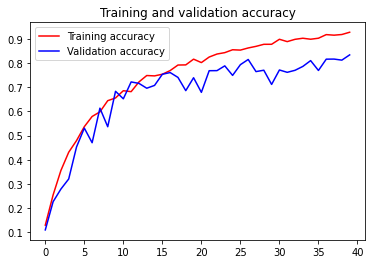

<Figure size 432x288 with 0 Axes>

In [22]:
# GRÁFICO DE LA PRECISIÓN CON DATOS DE ENTRENAMIENTO Y DE VALIDACIÓN

import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [23]:
# PREDICCIONES

# Se aplica el modelo para los datos de validación
predictions = model.predict(X_t)

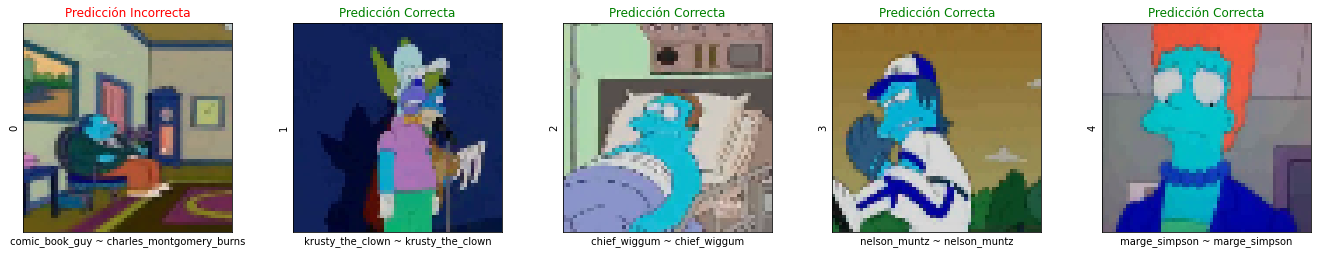

In [24]:
# GRÁFICO PARA PREDICCIONES

# Se realiza un gráfico para las predicciones en el cual se indica si la clasificación es correcta o no.

plt.figure(figsize=(30, 10))
i = 0
while i < 5:
    image, actual_label = X_t[i], y_t[i]
    predicted_label = np.argmax(predictions[i])
    plt.subplot(3, 8, i+1)
    plt.tight_layout()
    plt.xticks([])
    plt.yticks([])
        
    plt.imshow(image)
    
    if predicted_label == actual_label: 
      color, label = ('green', "Predicción Correcta")
    else:
      color, label = ('red', "Predicción Incorrecta") 
  
    plt.title(label, color=color)
      
    plt.xlabel(" {} ~ {} ".format(
        MAP_CHARACTERS[actual_label],
      MAP_CHARACTERS[predicted_label]))
       
    plt.ylabel(i)
   
    i += 1


In [25]:
# MATRIZ DE CONFUSIÓN
# Creación de la matriz de confusión
from sklearn.metrics import confusion_matrix
import numpy as np

confusion = confusion_matrix(y_t, np.argmax(predictions,axis=1))
confusion

array([[34,  0,  0,  1,  0,  0,  0, 13,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 50,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 41,  1,  0,  0,  1,  3,  0,  0,  3,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  2, 41,  1,  0,  0,  3,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 48,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  1,  0],
       [ 0,  0,  0,  2,  0, 44,  0,  1,  0,  1,  0,  0,  0,  0,  0,  1,  0,  0],
       [ 0,  0,  0,  1,  0,  0, 45,  4,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 50,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  2,  0,  0,  0,  0, 45,  1,  2,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  1,  0,  0,  0,  0, 49,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  0,  3,  0,  0,  0,  0,  6,  0,  0, 40,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 50,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  1,  1,  0, 

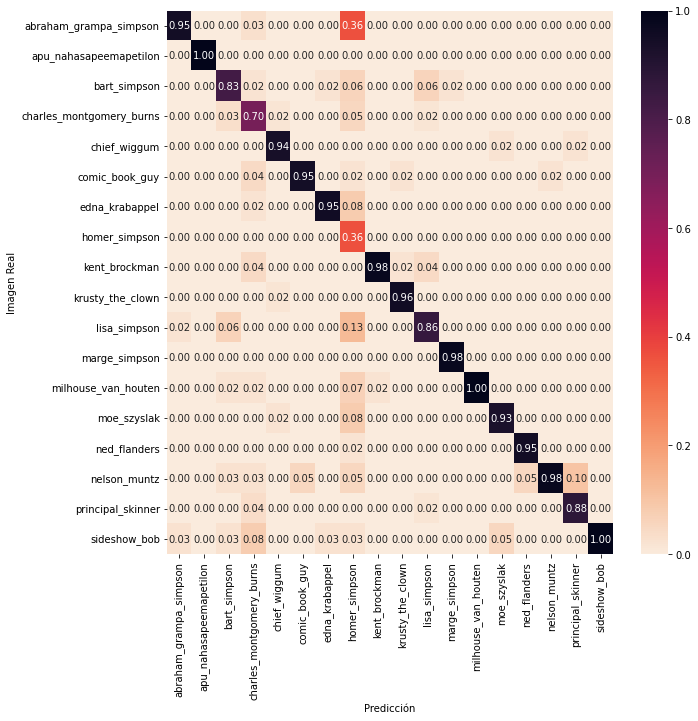

In [37]:
import seaborn as sns
# normalize the matrix to be in percentages
confusion = confusion.astype('float') / confusion.sum(axis=0)[:, np.newaxis]
# make a plot for the confusion matrix
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(confusion, annot=True, fmt='.2f', 
            xticklabels=[MAP_CHARACTERS[c] for c in MAP_CHARACTERS], 
            yticklabels=[MAP_CHARACTERS[c] for c in MAP_CHARACTERS],
            # cmap="Blues"
            cmap="rocket_r"
            )
plt.ylabel('Imagen Real')
plt.xlabel('Predicción')
# plot the resulting confusion matrix
plt.savefig("confusion-matrix.png")
# plt.show()